# Transmission Line Fault Analysis

Predicts symmetrical and unsymmetrical short circuit faults on a transmission line<br><br>
SymmetRical faults: Symmetrical faults maintain the systems symmetry even after a fault occurs. Three phase to ground fault (LLLG), it is one of the most severe faults and also rare<br><br>
Unsymmetrical faults: Unsymmetrical faults are the most common Single line to ground fault (LG), double line to ground fault (LLG)

In [75]:
# Importing libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance



## Data Loading and Overview

In [76]:
# url = r"C:\Users\owner\OneDrive\Desktop\backend\Fault_Analysis\merged_dataset.csv"
url = r"C:\Users\owner\OneDrive\Desktop\ML_projects\Fault_Analysis\merged_dataset.csv"

def load_data(url):
    df = pd.read_csv(url, sep=",")
    return df

In [77]:
df = load_data(url)

In [78]:
df = df.copy()

In [79]:
df.head()

,t,Va,Vb,Vc,Ia,Ib,Ic,Fault
0,0.0000,123.673155,-318.714610,195.041455,3827.709068,-9954.681312,6126.972245,0
1,0.0001,132.928422,-319.851525,186.923103,4117.440004,-9991.463731,5874.023726,0
2,0.0002,142.052661,-320.672826,178.620166,4403.112401,-10018.387070,5615.274666,0
3,0.0003,151.036833,-321.177694,170.140861,4684.443276,-10035.424470,5350.981195,0
4,0.0004,159.872046,-321.365624,161.493578,4961.154162,-10042.558910,5081.404750,0


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16004 entries, 0 to 16003
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       16004 non-null  float64
 1   Va      16004 non-null  float64
 2   Vb      16004 non-null  float64
 3   Vc      16004 non-null  float64
 4   Ia      16004 non-null  float64
 5   Ib      16004 non-null  float64
 6   Ic      16004 non-null  float64
 7   Fault   16004 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1000.4 KB


In [81]:
df.shape

(16004, 8)

In [82]:
df.describe()

,t,Va,Vb,Vc,Ia,Ib,Ic,Fault
count,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000
mean,0.200000,0.843025,0.074239,-0.774321,811.617302,80.453805,-892.071107,0.750187
std,0.115503,185.158509,228.305732,214.337091,25806.937879,20084.270608,27068.159572,1.089830
min,0.000000,-321.337862,-399.758521,-439.906216,-75450.670310,-75452.398310,-101459.969000,0.000000
25%,0.100000,-132.925858,-211.819511,-165.674065,-8867.564064,-8165.421349,-8931.921277,0.000000
50%,0.200000,2.755851,0.236431,-2.427893,174.618721,69.461964,-279.759159,0.000000
75%,0.300000,132.925860,211.819511,170.141151,9026.111438,8165.421349,8662.374220,2.000000
max,0.400000,321.337865,399.792289,440.461693,104412.724800,78820.581670,75455.416660,3.000000


## Data Cleaning

In [83]:
df= df.drop(['t'], axis=1)

In [84]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.sum()>0:
        print(missing_values[missing_values]>0)
    else:
        print("No missing values")


def check_duplicates(df):
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"Duplicated rows: {duplicates}")
        # df = df.drop_duplicates(inplace=True)
        # dropped = df.duplicated().sum()
        # print(f"\nDuplicates: {dropped}")
    else:
        print("There are no duplicates")

In [85]:
check_missing_values(df)
check_duplicates(df)

No missing values
Duplicated rows: 4076


In [86]:
check_duplicates(df)

Duplicated rows: 4076


In [87]:
#Saving cleaned dataset to csv
# df.to_csv("Clean_fault_analysis.csv", index=False)

## Exploratory Data Analysis

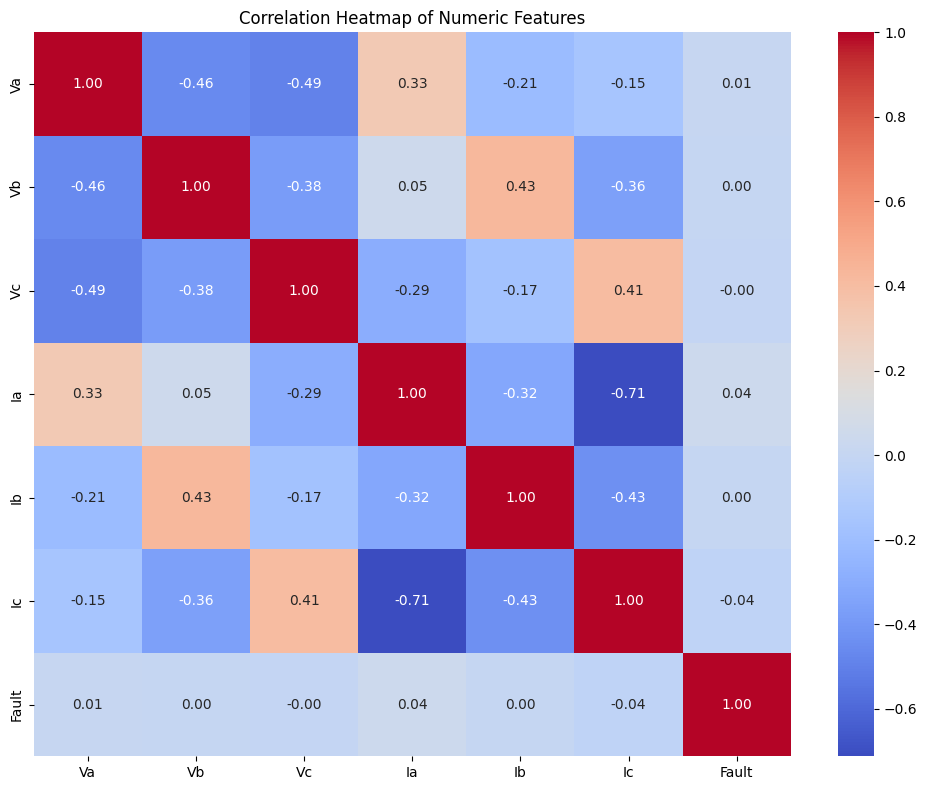

In [88]:
num_features = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(num_features.corr(), annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()



Correlation of numeric variables with the target:
Ia    0.037512
Va    0.005330
Ib    0.000897
Vb    0.000317
Vc   -0.004088
Ic   -0.036430
Name: Fault, dtype: float64


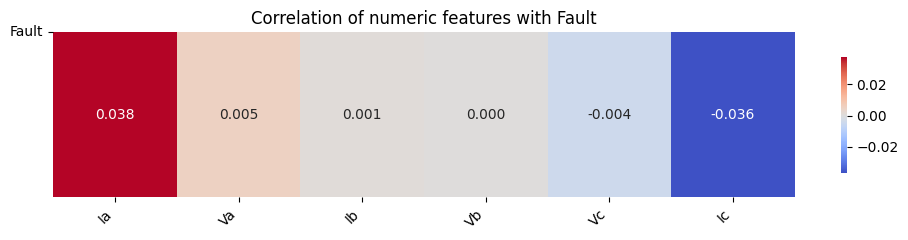

In [89]:

def corr_with_target(df, target):
    """
    Computes and prints correlation of all numeric columns with the target column.
    """

    # Select numeric columns
    num_df = df.select_dtypes(include='number')

    # Compute correlations with target
    corr_with_target = num_df.corr()[target].drop(labels=[target]).sort_values(ascending=False)

    # Print results
    print("\nCorrelation of numeric variables with the target:")
    print(corr_with_target)

    corrs_df = corr_with_target.to_frame(name = 'corr').T #Shape (1, n)

    #Heatmap
    plt.figure(figsize=(10,2.5))
    sns.heatmap(corrs_df, annot=True, fmt = ".3f",cmap="coolwarm",center = 0,
        # vmin = -1,
        # vmax = 1,
        cbar_kws = {'orientation': 'vertical', 'shrink': 0.7}
    )

    plt.xticks(rotation= 45, ha = 'right')
    plt.yticks([0], [target], rotation= 0)
    plt.title(f"Correlation of numeric features with {target}", fontsize=12)
    plt.tight_layout()
    plt.show()

corr_with_target(df, 'Fault')

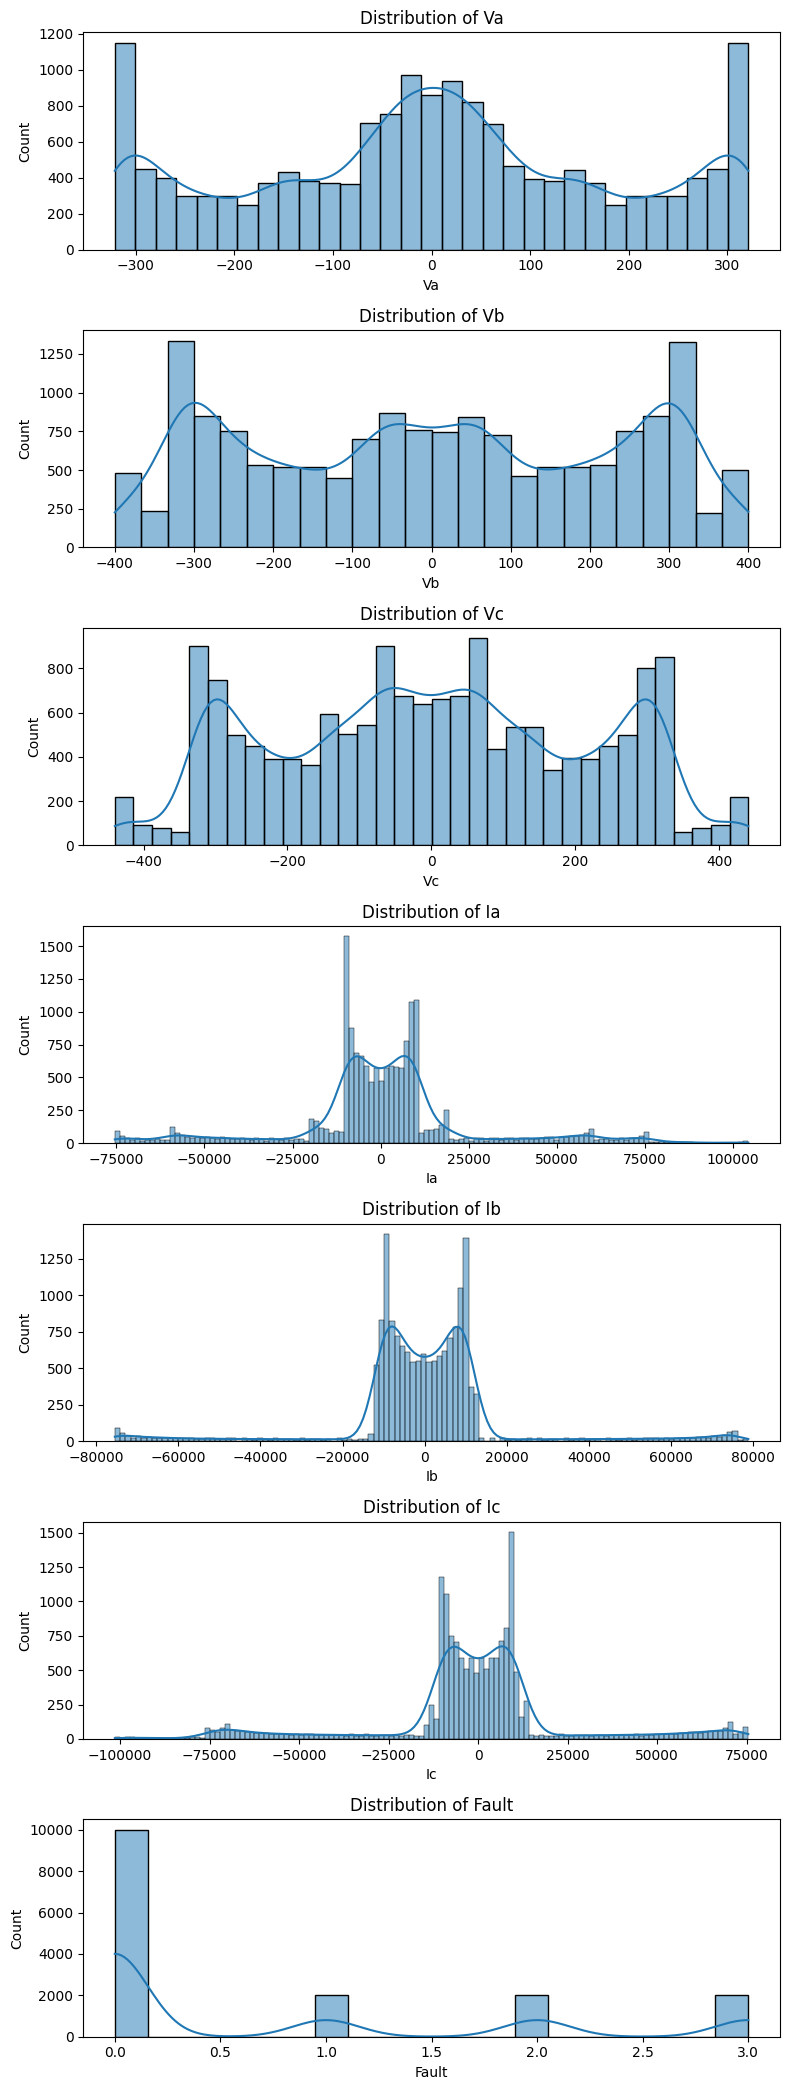

In [90]:
# Plot histograms for each column using seaborn's histplot
def histogram(features = num_features):
    numeric_columns = features.columns.tolist()

    fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(8, 3 * len(numeric_columns)))

    for ax, col in zip(axes, numeric_columns):
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()

histogram()

In [91]:
df.columns

Index(['Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic', 'Fault'], dtype='object')

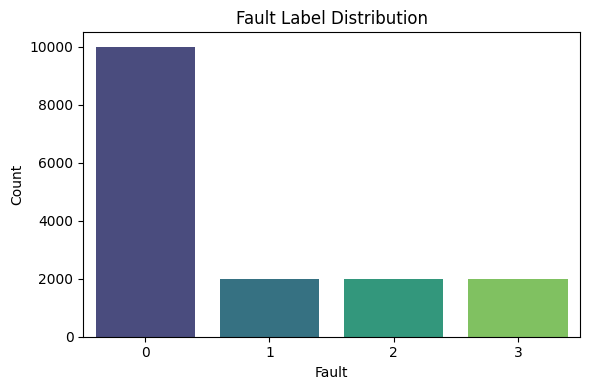

In [92]:
# Visualize the distribution of the 'Fault' column
def distribution(col = df["Fault"]):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title('Fault Label Distribution')
    plt.xlabel('Fault')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

distribution()

The "Fault" column contains categorical labels representing different system conditions: <br>
0 = No fault (Normal operation)

1 = LLLG fault (Three-phase-to-ground fault)

2 = LG fault (Line-to-ground fault)

3 = LLG fault (Line-line-to-ground fault)

In [93]:
df = df.replace({"Fault":{0: "No fault", 1: "LLLG fault", 2 :"LG fault", 3: "LLG fault"}})

The "Fault" column contains categorical labels representing different system conditions: <br>
0 = No fault (Normal operation)

1 = LLLG fault (Three-phase-to-ground fault)

2 = LG fault (Line-to-ground fault)

3 = LLG fault (Line-line-to-ground fault)

In [94]:
df["Fault"].unique()

array(['No fault', 'LG fault', 'LLG fault', 'LLLG fault'], dtype=object)

## Preprocessing

Should include some feature engineering to increase the correlation of the low signal features<br>
drop the column for time as it doesn't provide any predictive information

**Feature Engineering**

Time domain features<br>
RMS: rms represents the effective power carrying level of the signal, short circuit fault causes a drop in voltage rms (the faults being)<br>
Peak-to-peak: faults causes high peaks and deep troughs in the peak to peak voltage and current <br>
<br>
Frequency Domain Features <br>
dominant_frequency: normal frequency should be 50Hz or 60Hz, a change in this indicates a fault in the line<br>
fast fourier transform energy: fault cause energy surges in high-frequency bands<br>
<br>
Phase relationship features<br>
voltage imbalance: asymmetrical fault causes voltage imbalance on the lines: voltage imbalance = std(Va, Vb, Vc)/ mean(Va, Vb, Vc)<br>
currnent imbalance: faulted phases carry unusually high current: current_imbalance = std(Ia,Ib,Ic) / mean(Ia,Ib,Ic)<br>
Phase-to-Phase Voltage Differences (Vab, Vbc, Vca): Phase-to-Phase voltage changes when fault occurs<br>
Phase-to-Phase Current Differences (Iab, Ibc, Ica): faulted phases experience dramatic current spikes<br>
<br>
Power Features<br>
Total real power: total real power drops and increases rapidly during l-g, l-l faults and short circuit faults due to low impedance<br>
Apparent power: fault distorts apparent power<br>
power factor: fault causes sudden changes in the power factor real_power/apparent power

In [95]:
df.columns

Index(['Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic', 'Fault'], dtype='object')

In [ ]:
#Using rolling window because transmission line signals change  very fast and it allows the engineered feature to reflect recent signal behaviour, not the entire signal

def engineered_features(df, window=100):
    # df=df.copy()
    volt_cols = ['Va', 'Vb', 'Vc']  # Phase voltages
    curr_cols = ['Ia', 'Ib', 'Ic']  # Phase currents
    all_cols = volt_cols + curr_cols 

    # #Time domain features
    # #Rolling Root mean square
    # for col in all_cols:
    #     df[f"{col}_rms"] = df[col].rolling(window).apply(lambda x: np.sqrt(np.mean(x**2)), raw= True)

    # #Rolling peak-to-peak
    # for col in all_cols:
    #     df[f"{col}_ptp"] = df[col].rolling(window).apply(lambda x: np.ptp(x), raw=True)
    # #commenting out because I got a lot of empty values

In [98]:
engineered_features(df)

In [100]:
df.head(100)

,Va,Vb,Vc,Ia,Ib,Ic,Fault,Va_rms,Vb_rms,Vc_rms,Ia_rms,Ib_rms,Ic_rms,Va_ptp,Vb_ptp,Vc_ptp,Ia_ptp,Ib_ptp,Ic_ptp
0,123.673155,-318.714610,195.041455,3827.709068,-9954.681312,6126.972245,No fault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,132.928422,-319.851525,186.923103,4117.440004,-9991.463731,5874.023726,No fault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,142.052661,-320.672826,178.620166,4403.112401,-10018.387070,5615.274666,No fault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,151.036833,-321.177694,170.140861,4684.443276,-10035.424470,5350.981195,No fault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,159.872046,-321.365624,161.493578,4961.154162,-10042.558910,5081.404750,No fault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-75.746007,308.343534,-232.597528,-2328.029834,9624.416910,-7296.387076,No fault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,-85.518603,311.035889,-225.517287,-2633.740098,9709.769154,-7076.029056,No fault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,-95.206802,313.421290,-218.214488,-2936.851181,9785.539028,-6848.687847,No fault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,-104.801043,315.497381,-210.696338,-3237.063950,9851.651756,-6614.587806,No fault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Splitting and Scaling

In [ ]:
X = df.drop(columns="Fault")
y = df['Fault']

In [ ]:
#Scaling 
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=234, stratify=y)

## Modelling

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbours": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Ada Boost": AdaBoostClassifier(),
    "Extra Trees": ExtraTreesClassifier()
}

Training LogisticRegression...
LogisticRegression Accuracy: 0.624
              precision    recall  f1-score   support

    LG fault       0.24      0.20      0.22       400
   LLG fault       0.44      0.07      0.12       400
  LLLG fault       0.23      0.19      0.21       400
    No fault       0.73      0.91      0.81      2001

    accuracy                           0.62      3201
   macro avg       0.41      0.34      0.34      3201
weighted avg       0.57      0.62      0.58      3201



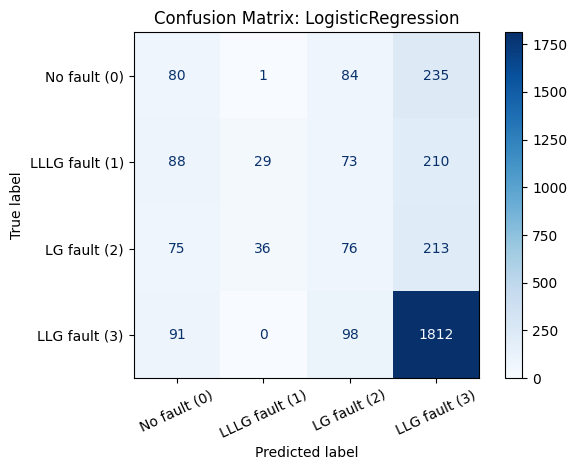

Training Random Forest...
Random Forest Accuracy: 0.999
              precision    recall  f1-score   support

    LG fault       1.00      1.00      1.00       400
   LLG fault       1.00      1.00      1.00       400
  LLLG fault       1.00      1.00      1.00       400
    No fault       1.00      1.00      1.00      2001

    accuracy                           1.00      3201
   macro avg       1.00      1.00      1.00      3201
weighted avg       1.00      1.00      1.00      3201



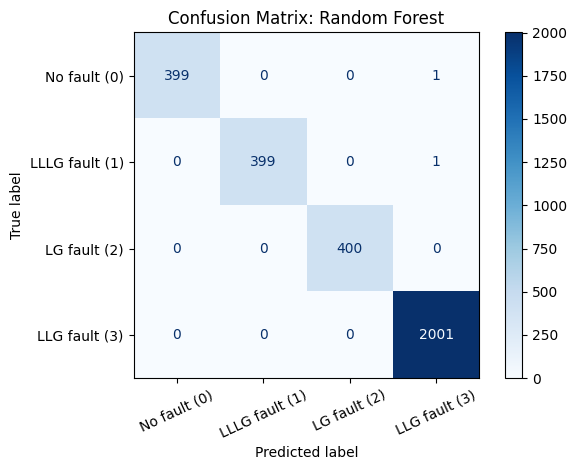

Training Decision Tree...
Decision Tree Accuracy: 0.999
              precision    recall  f1-score   support

    LG fault       1.00      1.00      1.00       400
   LLG fault       1.00      0.99      1.00       400
  LLLG fault       1.00      1.00      1.00       400
    No fault       1.00      1.00      1.00      2001

    accuracy                           1.00      3201
   macro avg       1.00      1.00      1.00      3201
weighted avg       1.00      1.00      1.00      3201



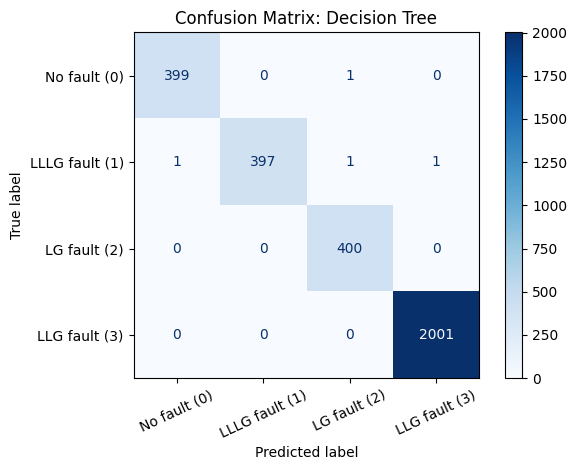

Training K-Nearest Neighbours...
K-Nearest Neighbours Accuracy: 0.990
              precision    recall  f1-score   support

    LG fault       0.97      0.95      0.96       400
   LLG fault       1.00      1.00      1.00       400
  LLLG fault       1.00      1.00      1.00       400
    No fault       0.99      0.99      0.99      2001

    accuracy                           0.99      3201
   macro avg       0.99      0.99      0.99      3201
weighted avg       0.99      0.99      0.99      3201



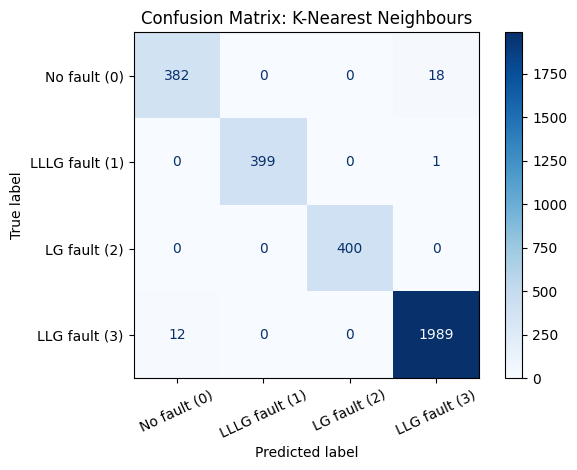

Training Naive Bayes...
Naive Bayes Accuracy: 0.933
              precision    recall  f1-score   support

    LG fault       0.76      0.80      0.78       400
   LLG fault       1.00      0.87      0.93       400
  LLLG fault       0.99      1.00      0.99       400
    No fault       0.95      0.96      0.95      2001

    accuracy                           0.93      3201
   macro avg       0.92      0.91      0.91      3201
weighted avg       0.94      0.93      0.93      3201



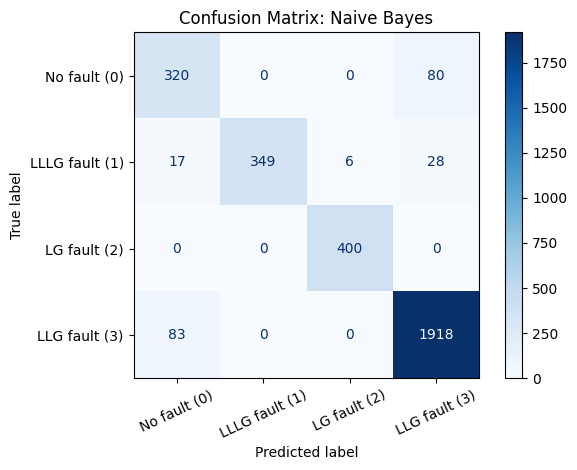

Training Ada Boost...
Ada Boost Accuracy: 0.919
              precision    recall  f1-score   support

    LG fault       0.69      0.80      0.74       400
   LLG fault       0.91      0.94      0.92       400
  LLLG fault       1.00      0.91      0.95       400
    No fault       0.96      0.94      0.95      2001

    accuracy                           0.92      3201
   macro avg       0.89      0.90      0.89      3201
weighted avg       0.93      0.92      0.92      3201



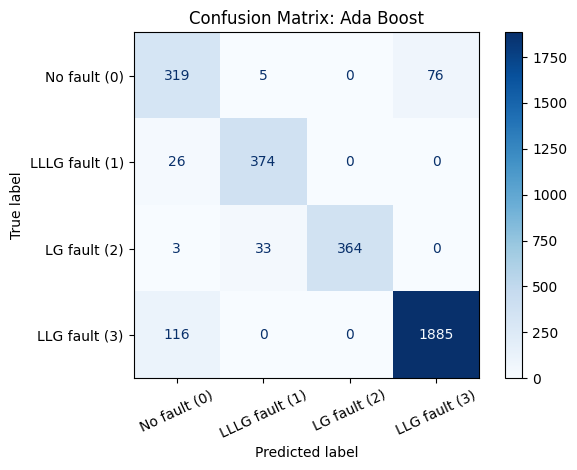

Training Extra Trees...
Extra Trees Accuracy: 0.999
              precision    recall  f1-score   support

    LG fault       1.00      1.00      1.00       400
   LLG fault       1.00      1.00      1.00       400
  LLLG fault       1.00      1.00      1.00       400
    No fault       1.00      1.00      1.00      2001

    accuracy                           1.00      3201
   macro avg       1.00      1.00      1.00      3201
weighted avg       1.00      1.00      1.00      3201



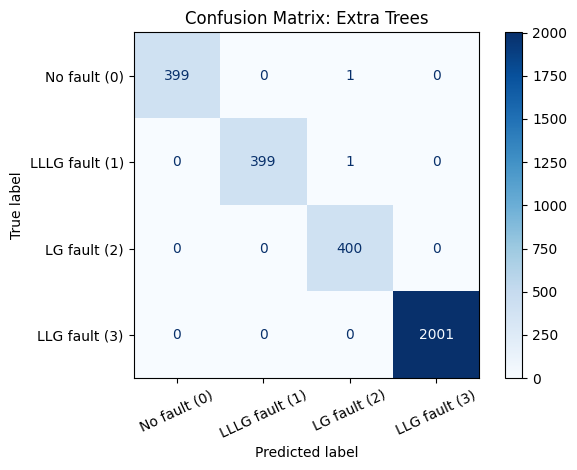

,Model,Accuracy
1,Random Forest,0.999375
6,Extra Trees,0.999375
2,Decision Tree,0.998750
3,K-Nearest Neighbours,0.990316
4,Naive Bayes,0.933146
5,Ada Boost,0.919088
0,LogisticRegression,0.623868


In [ ]:
# Initializing a dictionary to store the models
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.3f}")

    #Adding confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=['No fault (0)',"LLLG fault (1)", "LG fault (2)", "LLG fault (3)" ])
    print(classification_report(y_test, y_pred, zero_division=1))

    #Plotting with model name as title
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xticks(rotation = 25)
    plt.tight_layout()
    plt.show()

result_df = pd.DataFrame(results.items(), columns=["Model", "Accuracy"])
result_df = result_df.sort_values(by="Accuracy", ascending=False)
result_df.reset_index(drop=True)
result_df